# Frontier Notation

This notebook considers the design and implementation of the next generation of heterogenous agent model (HAM) notation.

In [3]:
%load_ext tikzmagic

## Definitions

### Bellman Equation

A [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation) is a formulation of the value to an agent of each state acting optimally within a dynamic decision problem. From this value function it is easy to compute the optimal policy for the agent. The Bellman equation takes the form (**Definition 1**):

$$V(x) = \text{max}_{a \in \Gamma(x)} F(x,a) + \beta V(T(x,a))$$

Where:

* $a \in A$, the set of actions available
* $x \in X$, the set of states
* $\Gamma : X \rightarrow \mathscr{B}(A)$ constraints the actions available in state X
* $F(x,a)$ is the payoff to the agent of taking action $a$ in state $x$
* $T: X \times A \rightarrow X$ is a transition function determining the state in the next period
* $\beta$ is a discount factor on future payoffs.

This representation of Bellman equation assumes a deterministic model. If T is a stochastic function, as it is in many cases in economics, then the value function is defined in terms of expectations. (**Definition 2**):

$$V(x) = \text{max}_{a \in \Gamma(x)} F(x,a) + \beta E[V(T(x,a))]$$

We will use the deterministic version of this equation for simplicity unless there's a good reason to use the probabilistic version.

Note that with this rendition of the problem, there is only one state space, action space, value function, etc. that is repeated "over time".

### Variations

The above formulation of the Bellman equation assumes that the problem is structured identically at every control point (opportunity for the agent to choose an action $a$) and that there is only one control point. For various applications in economics, we are interested in other kinds of problems, such as those with:

* **V1**. Multiple control points
* **V2**. Inconsistent problems over time

While it may be tempting to consider these the same kind of challenge, we will examine each case rigorously in isolation and see if that conclusion can be confirmed.

#### V1. Multiple control points

**V1** (Variation 1) can be understood as a decomposition of the problem described in **Definition 1**. For reasons connected to those described in "Mathematics of Discrete Time Stochastic Control Processes in Macroeconomics", problems of the following form, for $C$ (sequential) control variables, can be shown to have an equivalent problem in the above form: (Note that the variables here are in italic font)

* $(\mathit{A}_0, ..., \mathit{A}_C)$ is a sequence of sets of action spaces such that $A = \mathit{A}_0 \times ... \times \mathit{A}_c$
* $(\mathit{X}_0, ...,\mathit{X}_C)$ is a sequence of sets of state spaces such that $X = \mathit{X}_0 \times ... \times \mathit{X}_c$
* $(\mathit{\Gamma}_0, ..., \mathit{\Gamma}_C)$ is a sequence of contraints. $\mathit{\Gamma}_c: \mathit{X}_c \rightarrow \mathscr{B}(\mathit{A}_c)$
* $(\mathit{F}_0, ..., \mathit{F}_C)$ is a sequence reward functions. $\mathit{F}_c: \mathit{X}_c \times \mathit{A}_c \rightarrow \mathbb{R}$
* $(\mathit{T}_0, ..., \mathit{T}_C)$ is a sequence of transitions functions $\mathit{T}_c: \mathit{X}_c \times \mathit{A}_c \rightarrow \mathit{X}_{(c+1) mod C}$. **Note incrementing of state space in transition function.**
* *Unknown:* What happens to $\beta$ the discount factor?

With these sequences of subproblems defined, the decomposed into $C$ mutually recursive Bellman-like *Carroll equations* for $x \in \mathit{X}_c$ is:

$$\mathit{V}_c(x) = \text{max}_{a \in \mathit{\Gamma}_c(x)} \mathit{F}_c(x,a) + \beta \mathit{V}_{(c+1) mod C}(\mathit{T}_c(x,a))$$

In principle, the original problem could be defined in such a way that the sub-problems need not have a natural sequential order. However, in these cases multiple ordering will suffice.

Note that these subproblems are not isolated from each other. The transition function $\mathit{T}_c$ of each problem contains a "reference" to the state space in the next "stage" $\mathit{X}_{c+1}$.

These truly are "subproblems" of the original problem specification, as the original specification can be reconstituted from the details of the subproblems. For example, $A = \mathit{A}_0 \times ... \times \mathit{A}_c$, $X = \mathit{X}_0 \times ... \times \mathit{X}_c$ and so on. The problem remains an infinite horizon problem, but decomposed into $C$ simpler sub-problems with reduced action and state spaces.

#### V2. Inconsistent problems over time

There is a sense in which the challenge of inconsistency over time is similar to the challenge of multiple control points. We will see that the formal descriptions of the challenges are similar. However, there are some differences:

1. Whereas multiple control points allow us to break a problem down into $C$ subproblems with smaller state and action spaces than the original problem, inconsistency over time makes a problem *more* complex because it *increases* the size of the problem.
2. One of these things will hold for any actually specified inconsistent problem: (a) the inconsistent problem is a finite problem, or (b) the inconsistent problem can be rewritten as a consistent problem with time index in its state space.

We will formally define the time inconsistent problem in terms of the following, assuming for now that it is a finite problem:

* $A_0, ..., A_K$ is a sequence of sets of action spaces
* $X_0, ...,X_K$ is a sequence of sets of state spaces
* $\Gamma_0, ..., \Gamma_C$ is a sequence of contraints. $\Gamma_k: X_k \rightarrow \mathscr{B}(A_k)$
* $F_0, ..., F_K$ is a sequence reward functions. $F_k: X_k \times A_k \rightarrow \mathbb{R}$
* $T_0, ..., T_K$ is a sequence of transitions functions $T_k: X_k \times A_k \rightarrow X_{k+1}$.
* $\beta$, a discount factor for utility between time steps **Or does this vary?***

With these sequences of subproblems defined, the Bellman-like *Carroll equations* are:

$$V_K(x) = \text{max}_{a \in \Gamma_K(x)} F_K(x,a)$$
$$V_k(x) = \text{max}_{a \in \Gamma_k(x)} F_k(x,a) + \beta V_{k+1}(T_k(x,a))$$

Because this is a finite model, this can be solved simply via backwards induction without looking for a convergent value of $V_k$. Note that as before, the transition functions $T_k$ link the problem at $k$ to the state space of the next time $X_{k+1}$.

If the problem for any $k$ carries as much information as one problem in the mode of **Definition 1**, then the time inconsistent problem will have a longer minimum description lengtht than the original infinite horizon problem. This is in contrast to the decomposition of the infinite horizon problem in to multiple stages based on multiple control variables; in the latter case, the decomposition contains no new information.

### Carroll Problems: a proposed unified formalism
   
The two variations on the classic Bellman equation above have clear formal similarities, though they have some important differences as well. For the sake of clarity, we will formally define a *Carroll Problem* in a way that both kinds of variation, and others besides it, can be represented easily.

A Carroll Problem $\mathbb{C}$ is a set of subproblems $\{\mathcal{C}_0, ... \mathcal{C}_I\}$.

Each subproblem $\mathcal{C}_i$ is a tuple of the following:

* A definition of the local problem:
    * $A_i$, the set of actions available
    * $X_i$, the set of states
    * $\Gamma_i : X \rightarrow \mathscr{B}(A)$ constraints the actions available in state X
    * $F_i: X \times A \rightarrow \mathbb{R}$ is the payoff to the agent of taking action $a$ in state $x$
* A information about the transition to the next problem. This could be:
    * Null, in which case the problem is terminal, or ...
    * A tuple containing:
        * An index to another subproblem $j$
        * $T_i: X_i \times A_i \rightarrow X_j$, a transition function determining the state in the next problem
        * $\beta_i$ is a discount factor on future payoffs.

The Carroll problem can then be solved using backwards induction by computing the value functions $V_i : X_i \rightarrow \mathbb{R}$:

$$V_i(x) = \text{max}_{a \in \Gamma_i(x)} F_i(x,a) + \beta_i V_{j}(T_i(x,a))$$

or for the terminal subproblems

$$V_i(x) = \text{max}_{a \in \Gamma_i(x)} F_i(x,a)$$

Note that the connection between subproblems can be represented as a directed acyclic graph in the case of repetitions.

**Quandary**. How does one represent an infinite horizon problem with a "terminal solution" ?

In [18]:
## Visualizing the relationship between subproblems of Portfolio Consumption

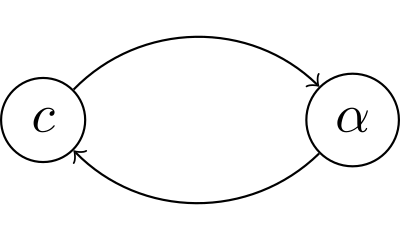

In [19]:
%%tikz -f svg

\usetikzlibrary{shapes}

\node[shape=circle,draw=black] (c) at (0,0) {$c$};
\node[shape=circle,draw=black] (alpha) at (2,0) {$\alpha$};

\path [->] (c) edge [bend left=45] node[left] {} (alpha);
\path [->] (alpha) edge [bend left=45] node[right] {} (c);

### General Modeling Desiderata

Once we have all of the information necessary to define a problem, we may be inclined to reshape it into a more tractable form. In general, we would like our models to be easy to understand and easy to solve. These two desiderata may be at odds with each other and can be addressed separately.

* D1. Minimal computational complexity of solution
* D2. Minimal programmatic description.

#### D1. Minimal computational complexity of solution

#### D2. Minimal programmatic description



## Roadmap

### HARK 1.0

#### Shocks, State, Control, and Reward variables

Consider this version of the portfolio choice consumption saving problem.

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
\Risky | ~Dist | Shock | c | --
\TranShk | ~Dist | Shock | c | --
\PermShk | ~Dist | Shock | c | --
\Rport | \Rport = \PortShare * \Risky + (1 - \PortShare) * R | Update | c | --
$b$ | b_{t} = a_{t-1} \RPort | Update | c | --
$p$ | p_{t}=p_{t-1}\PermShk_{t} | Update | c | --
$y$ | y_{t} = p_{t}\TranShk_{t} | Update | c | --
$m$ | m_{t} = b_{t} + y_{t} | Update | c | --
$c$ | c | Control | c | U(c)
$a$ | a_{t} = m_{t} - c_{t} | Update | $\alpha$ | --
$\alpha$| $\alpha$ | Control | $\alpha$ | 0

Here, there are threes kinds of variables: shocks ($\phi$, $\psi$, ...), state ($a$, $b$, ...)  and control ($c$ and $\PortShare$).

There is also another kind of value, a reward or utility value that in this case is dependent on a control variable.

#### Finite Horizon iteration

Repeat a problem a finite number of time $T$.


#### Backwards induction

For each control variable, compute the optimal policy.

This is done through the calculation of the Bellman equation:

$$V(x) = \text{max}_{a \in \Gamma(a)} F(x,a) + \beta V(T(x,a))  $$

Where $\Gamma$ are constraints on the actions available and $T$ is the transition function to the next state.

Note in this formulation $a$ and $x$ are considered in terms of the broader classes of State and Action 

Compute this with a time adjusted value function 



#### Market equilibria

Multiple agents interacting with a Market, with rational expectations of the behavior of the market.




### HARK 2.0

#### Arbitrary Problem Embeddings

Let a problem be defined as as set containing:
 - 
 - 
 - 
 - 
 - 
 - 
 
(This is all the information included in a Dolang document).
 


## Prior work

### Modeling different kinds of variables

Koller and Milch (2003) take the approach in their Multi-Agent Influence Diagrams (MAIDs) of using:
 - ovals for Chance variables or "decisions by nature"
 - rectangles for Decision variables (roughly equivalent to Control variables here)
 - diamonds for Utility variables, which correspond to utility gained by the agents.
 
 We can adapt this to the portfolio choice model as follows:


## Tools

There exist a number of tools that are designed for flexible notation for visualizing [probabilistic graphical models](http://www.utstat.toronto.edu/~rsalakhu/sta4273/notes/Lecture4.pdf) (see also [Koller and Friedman, 2009](https://djsaunde.github.io/read/books/pdfs/probabilistic%20graphical%20models.pdf))


### tikz BayesNet

https://github.com/jluttine/tikz-bayesnet

* LaTeX, builds on [Tikz](https://es.overleaf.com/learn/latex/TikZ_package)
* Plate notation
* Can handle factor graphs

### Daft

https://docs.daft-pgm.org/en/latest/

* Python based, used `matplotlib`
* Programmatic graph definition is nice
* built-in distinction between 'observed' and 'unobserved' variable




### GraphViz

https://stackoverflow.com/a/16334517

* Most flexible
* not LaTeX native
* Requires additional C dependencies

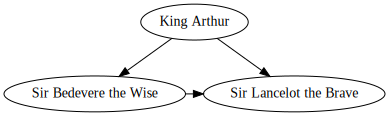

In [9]:
import graphviz as gv

dot = gv.Digraph(comment='The Round Table')

dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')

dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')

dot

## References


Koller, D., & Milch, B. (2003). Multi-agent influence diagrams for representing and solving games. Games and economic behavior, 45(1), 181-221.

Koller, D., & Friedman, N. (2009). Probabilistic graphical models: principles and techniques. MIT press.